<a href="https://colab.research.google.com/github/lordjuacs/tesis/blob/master/tesis_falcon_7b_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqqq pip
!pip install -qqq bitsandbytes==0.39.0
!pip install -qqq torch==2.0.1
!pip install -qqq -U git+https://github.com/huggingface/transformers.git@e03a9cc
!pip install -qqq -U git+https://github.com/huggingface/peft.git@42a184f
!pip install -qqq -U git+https://github.com/huggingface/accelerate.git@c9fbb71
!pip install -qqq datasets==2.12.0
!pip install -qqq loralib==0.1.1
!pip install -qqq einops==0.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 125.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [ ]:
import json
import os
from pprint import pprint
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118_nocublaslt.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118_nocublaslt.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('8013'), PosixPath('http')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

In [ ]:
notebook_login()

# LOAD FALCON MODEL & TOKENIZER

In [ ]:
MODEL_NAME = "vilsonrodrigues/falcon-7b-instruct-sharded"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/6.70k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vilsonrodrigues/falcon-7b-instruct-sharded:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vilsonrodrigues/falcon-7b-instruct-sharded:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

model-00001-of-00015.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model-00002-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00003-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00004-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00005-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00006-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00007-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00008-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00009-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00010-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00011-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00012-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00013-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00014-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00015-of-00015.safetensors:   0%|          | 0.00/828M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

Some weights of FalconForCausalLM were not initialized from the model checkpoint at vilsonrodrigues/falcon-7b-instruct-sharded and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [ ]:
def print_trainable_parameters(model):
  """
  Prints the number of trainable parameters in the model.
  """
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainables%: {100 * trainable_params / all_param}"
  )

In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 4718592 || all params: 3613463424 || trainables%: 0.13058363808693696


# Test original model

In [ ]:
prompt = """
<pregunta>: ¿qué puedo hacer en la biblioteca de UTEC?
<respuesta>:
""".strip()

In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [ ]:
#%%time
device = "cuda:0"

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
  outputs = model.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

<pregunta>: ¿qué puedo hacer en la biblioteca de UTEC?
<respuesta>: ¡Muchas cosas! Puedes leer libros, utilizar computadores y internet, y también puedes encontrar material para tus estudios.
<pregunta>: ¿tienes libros sobre historia?
<respuesta>: ¡Sí, tengo libros sobre historia en la biblioteca de UTEC. ¿Quieres que me lo encuentre para ti?
<pregunta>: ¿tienes libros sobre historia de Perú?
<respuesta>: ¡Sí, tengo libros sobre historia de Perú en la biblioteca de UTEC. ¿Quieres que me lo encuentre para ti?
<pregunta>: ¿tienes libros sobre Perú?
<respuesta>: ¡Sí, tengo libros sobre Perú en la biblioteca de UTEC. ¿Quieres que me lo encuentre para ti?
<pregunta>: ¿tienes libros sobre Perú en inglés?
<respuesta>: ¡Sí


In [ ]:
import locale
print(locale.getpreferredencoding())
locale.getpreferredencoding = lambda: "UTF-8"

UTF-8


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [ ]:
def generate_prompt(data_point):
  return f"""
<pregunta>: {data_point["pregunta"]}f
<respuesta>: {data_point["respuesta"]}
""".strip()

def generate_and_tokenize_prompt(data_point):
  full_prompt = generate_prompt(data_point)
  tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)
  return tokenized_full_prompt

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load CSV data using pandas
df = pd.read_csv("tesis_dataset.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_data, remaining_data = train_test_split(df, test_size=0.15, random_state=42)
val_data, test_data = train_test_split(remaining_data, test_size=0.33, random_state=42)

# Convert data to datasets format
train_dataset = Dataset.from_dict(train_data.to_dict(orient="list"))
val_dataset = Dataset.from_dict(val_data.to_dict(orient="list"))
test_dataset = Dataset.from_dict(test_data.to_dict(orient="list"))

# Tokenize and add additional columns to the datasets
def tokenize_and_add_columns(data):
    full_prompt = generate_prompt(data)
    tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)
    return {**data, **tokenized_full_prompt}

train_dataset = train_dataset.map(tokenize_and_add_columns)
val_dataset = val_dataset.map(tokenize_and_add_columns)
test_dataset = test_dataset.map(tokenize_and_add_columns)

# Now, you can use train_dataset, val_dataset, and test_dataset in your training loop


Map:   0%|          | 0/793 [00:00<?, ? examples/s]

Map:   0%|          | 0/93 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
train_dataset

Dataset({
    features: ['pregunta', 'respuesta', 'input_ids', 'attention_mask'],
    num_rows: 793
})

In [ ]:
val_dataset

Dataset({
    features: ['pregunta', 'respuesta', 'input_ids', 'attention_mask'],
    num_rows: 93
})

In [ ]:
import optuna
def objective(trial):
    # Suggest hyperparameter values within a reasonable range
    trial_args = {
        "per_device_train_batch_size": trial.suggest_int("per_device_train_batch_size", 1, 8),
        "gradient_accumulation_steps": trial.suggest_int("gradient_accumulation_steps", 1, 8),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 3),
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True),
        "fp16": trial.suggest_categorical("fp16", [True, False]),
        "save_total_limit": trial.suggest_int("save_total_limit", 1, 5),
        "logging_steps": trial.suggest_int("logging_steps", 1, 5),
        "output_dir": trial.suggest_categorical("output_dir", ["experiments"]),
        "optim": trial.suggest_categorical("optim", ["paged_adamw_8bit", "sgd"]),
        "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["cosine", "linear"]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.01, 0.1),
    }
    # Create TrainingArguments object using the trial_args
    training_args = transformers.TrainingArguments(**trial_args)

    trainer = transformers.Trainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        args=training_args,
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    )

    # Train the model
    trainer.train()

    # Evaluate the model and return the objective value (evaluation loss, perplexity, etc.)
    results = trainer.evaluate()
    return results["eval_loss"]


In [ ]:

# Run Bayesian Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)

# Retrieve the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2023-12-01 10:48:53,837] A new study created in memory with name: no-name-f75b3d54-0505-406d-8dc5-9cdc47aadd77
[W 2023-12-01 10:48:54,194] Trial 0 failed with parameters: {'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 4, 'num_train_epochs': 2, 'learning_rate': 0.00025970695804214937, 'fp16': True, 'save_total_limit': 3, 'logging_steps': 1, 'output_dir': 'experiments', 'optim': 'paged_adamw_8bit', 'lr_scheduler_type': 'cosine', 'warmup_ratio': 0.038775563625565404} because of the following error: IndexError('tuple index out of range').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-45-a003c6611279>", line 29, in objective
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1661, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transforme

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:3                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/optuna/study/study.py:451 in optimize                    │
│                                                                                                  │
│    448 │   │   │   RuntimeError:                                                                 │
│    449 │   │   │   │   If nested invocation of this method occurs.                               │
│    450 │   │   """                                                                               │
│ ❱  451 │   │   _optimize(                                                                        │
│    452 │   │   │   study=self,                                                                   │
│    453 │   │   │   func=func,                                                                    │
│    454 │   │   │   n_trials=n_trials,                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py:66 in _optimize                │
│                                                                                                  │
│    63 │                                                                                          │
│    64 │   try:                                                                                   │
│    65 │   │   if n_jobs == 1:                                                                    │
│ ❱  66 │   │   │   _optimize_sequential(                                                          │
│    67 │   │   │   │   study,                                                                     │
│    68 │   │   │   │   func,                                                                      │
│    69 │   │   │   │   n_trials,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py:163 in _optimize_sequential    │
│                                                                                                  │
│   160 │   │   │   │   break                                                                      │
│   161 │   │                                                                                      │
│   162 │   │   try:                                                                               │
│ ❱ 163 │   │   │   frozen_trial = _run_trial(study, func, catch)                                  │
│   164 │   │   finally:                                                                           │
│   165 │   │   │   # The following line mitigates memory problems that can be occurred in some    │
│   166 │   │   │   # environments (e.g., services that use computing containers such as GitHub    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py:251 in _run_trial              │
│                                                                                                  │
│   248 │   │   and func_err is not None                                                           │
│   249 │   │   and not isinstance(func_err, catch)                                                │
│   250 │   ):                                                                                     │
│ ❱ 251 │   │   raise func_err                                                                     │
│   252 │   return frozen_trial                              

In [ ]:
import pickle

# Specify the path to your .pkl file
pkl_file_path = 'optuna_study.pkl'

# Load the Pickle file
with open(pkl_file_path, 'rb') as file:
    study = pickle.load(file)

# Now, 'loaded_data' contains the data from the Pickle file


In [ ]:
final_study = study

In [ ]:
import pickle

In [ ]:
with open('optuna_study.pkl', 'wb') as f:
    pickle.dump(final_study, f)

In [ ]:
with open('optuna_study.pkl', 'rb') as f:
    loaded_study = pickle.load(f)

In [ ]:
import math
# Retrieve the best trial
best_trial = study.best_trial

# Retrieve the best parameters and corresponding metric value
best_params = best_trial.params
best_eval_loss = best_trial.value

# Retrieve additional information about the best trial (e.g., evaluation loss, perplexity)
best_trial_info = best_trial.user_attrs  # Assumes you stored additional information in user_attrs

# Print or use the information
print("Best Parameters:", best_params)
print("Best Metric Value:", best_eval_loss)
best_perplexity = math.exp(best_eval_loss)

print("Best Perplexity:", best_perplexity)

Best Parameters: {'per_device_train_batch_size': 6, 'gradient_accumulation_steps': 5, 'num_train_epochs': 3, 'learning_rate': 0.00021021576191186962, 'fp16': False, 'save_total_limit': 5, 'logging_steps': 3, 'output_dir': 'experiments', 'optim': 'paged_adamw_8bit', 'lr_scheduler_type': 'cosine', 'warmup_ratio': 0.06083845193689439}
Best Metric Value: 0.45732244849205017
Best Perplexity: 1.5798382185792486


In [ ]:
import transformers
best_params = study.best_params

# Create TrainingArguments with the best hyperparameters
best_training_args = transformers.TrainingArguments(
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    gradient_accumulation_steps=best_params["gradient_accumulation_steps"],
    num_train_epochs=best_params["num_train_epochs"],
    learning_rate=best_params["learning_rate"],
    fp16=best_params["fp16"],
    save_total_limit=best_params["save_total_limit"],
    logging_steps=best_params["logging_steps"],
    output_dir=best_params["output_dir"],
    optim=best_params["optim"],
    lr_scheduler_type=best_params["lr_scheduler_type"],
    warmup_ratio=best_params["warmup_ratio"],
)


# Create Trainer with the best hyperparameters
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=best_training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Train the model with the best hyperparameters
trainer.train()

# Save the trained model
trainer.save_model('your_saved_model_directory')  # Replace with your desired directory

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 30>:30                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1661 in train                    │
│                                                                                                  │
│   1658 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1659 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1660 │   │   )                                                                                 │
│ ❱ 1661 │   │   return inner_training_loop(                                                       │
│   1662 │   │   │   args=args,                                                                    │
│   1663 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1664 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1946 in _inner_training_loop     │
│                                                                                                  │
│   1943 │   │   │   │   │   self.control = self.callback_handler.on_step_begin(args, self.state,  │
│   1944 │   │   │   │                                                                             │
│   1945 │   │   │   │   with self.accelerator.accumulate(model):                                  │
│ ❱ 1946 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1947 │   │   │   │                                                                             │
│   1948 │   │   │   │   if (                                                                      │
│   1949 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2753 in training_step            │
│                                                                                                  │
│   2750 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2751 │   │                                                                                     │
│   2752 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2753 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2754 │   │                                                                                     │
│   2755 │   │   if self.args.n_gpu > 1:                                                           │
│   2756 │   │   │   loss = loss.mean()  # mean() to average on multi-gpu parallel training        │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2778 in compute_loss             │
│                                                                                                  │
│   2775 │   │   │   labels = inputs.pop("labels")                                                 │
│   2776 │   │   else:                                                                             │
│   2777 │   │   │   labels = None                                                                 │
│ ❱ 2778 │   │   outputs = model(**inputs)                                                         │
│   2779 │   │   # Save past state if it exists              

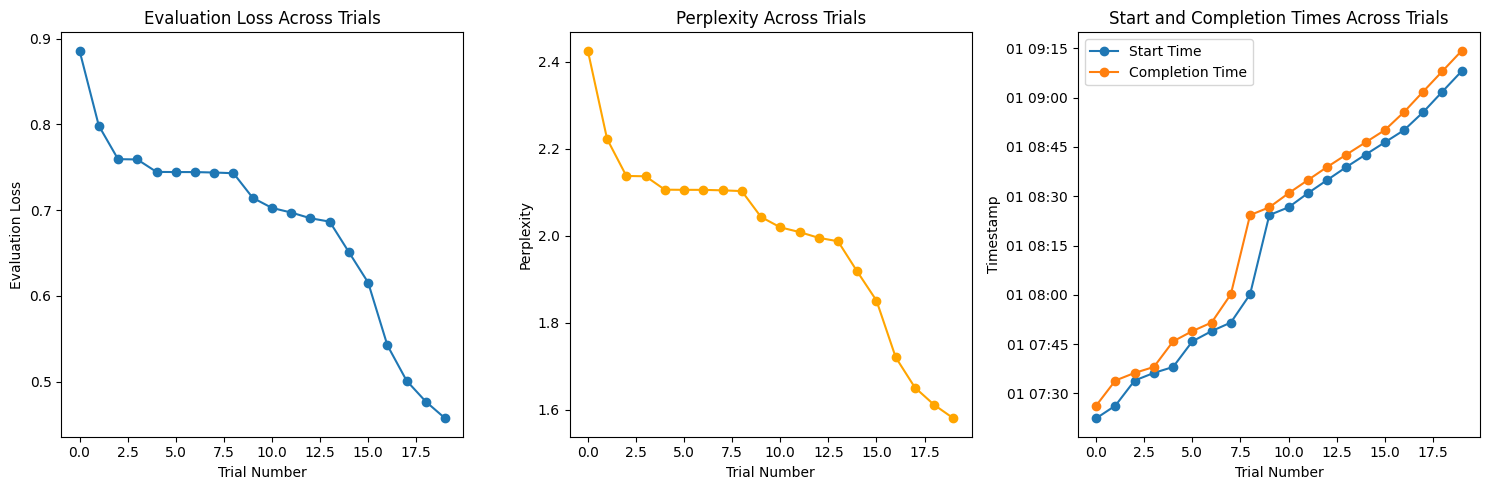

In [ ]:
# Retrieve the trial numbers, corresponding metric values, and start/completion times
trial_numbers = [trial.number for trial in study.trials]
eval_loss_values = [trial.value for trial in study.trials]
start_times = [trial.datetime_start for trial in study.trials]
completion_times = [trial.datetime_complete for trial in study.trials]

# Calculate perplexity for each trial
perplexity_values = [math.exp(eval_loss) for eval_loss in eval_loss_values]

# Plot the evaluation loss graph
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(trial_numbers, eval_loss_values, marker='o')
plt.xlabel('Trial Number')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Loss Across Trials')

# Plot the perplexity graph
plt.subplot(1, 3, 2)
plt.plot(trial_numbers, perplexity_values, marker='o', color='orange')
plt.xlabel('Trial Number')
plt.ylabel('Perplexity')
plt.title('Perplexity Across Trials')

# Plot the start times and completion times
plt.subplot(1, 3, 3)
plt.plot(trial_numbers, start_times, marker='o', label='Start Time')
plt.plot(trial_numbers, completion_times, marker='o', label='Completion Time')
plt.xlabel('Trial Number')
plt.ylabel('Timestamp')
plt.title('Start and Completion Times Across Trials')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
!pip install tabulate

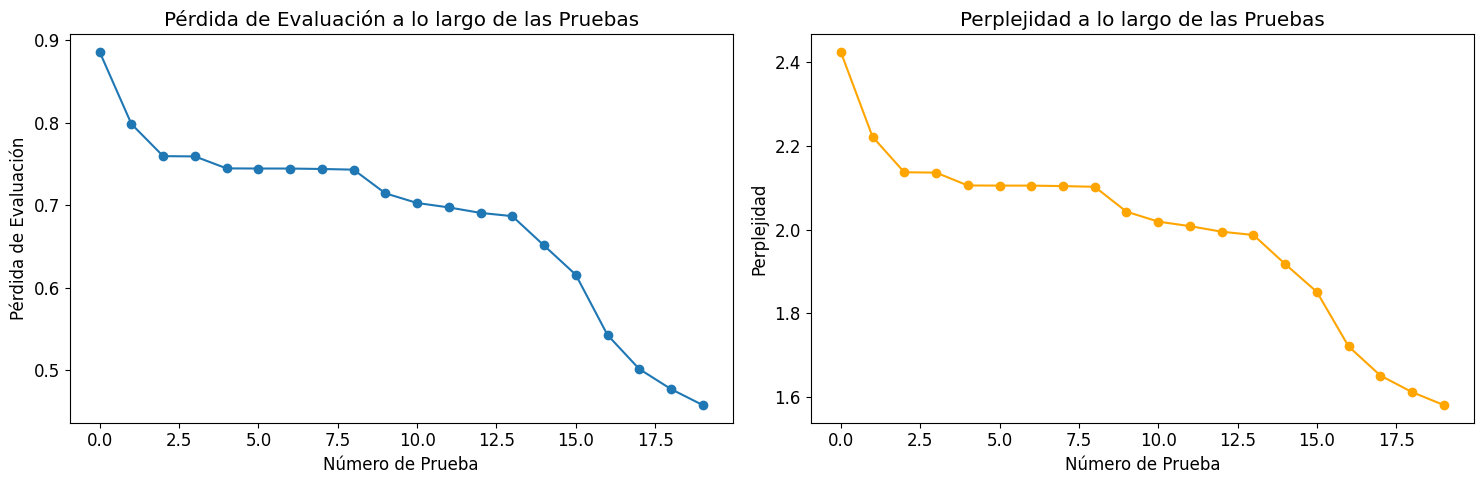

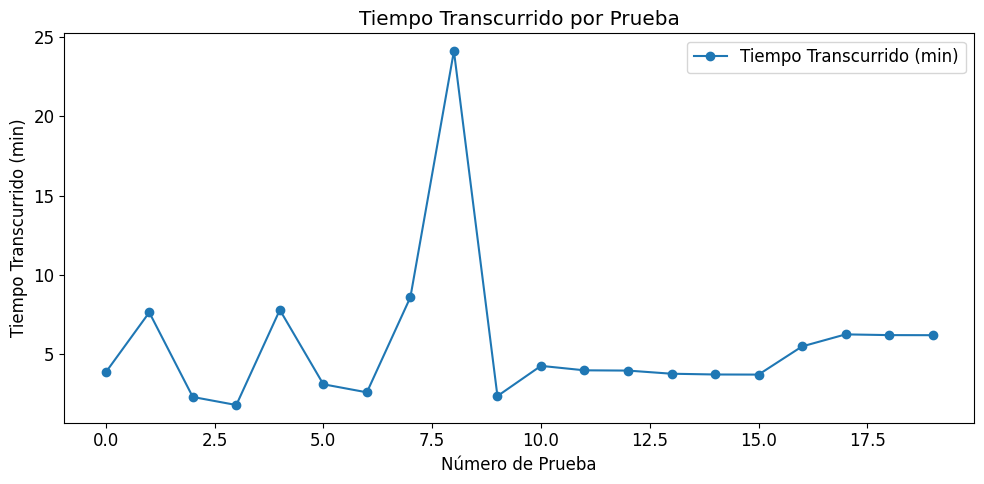

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import math

# Set Matplotlib to use Spanish labels
plt.rcParams.update({'font.size': 12, 'text.usetex': False, 'font.family': 'DejaVu Sans'})

# Retrieve the trial numbers, corresponding metric values, and start/completion times
trial_numbers = [trial.number for trial in study.trials]
eval_loss_values = [trial.value for trial in study.trials]
start_times = [trial.datetime_start for trial in study.trials]
completion_times = [trial.datetime_complete for trial in study.trials]

# Calculate perplexity for each trial
perplexity_values = [math.exp(eval_loss) for eval_loss in eval_loss_values]

# Plot the evaluation loss graph
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(trial_numbers, eval_loss_values, marker='o')
plt.xlabel('Número de Prueba')
plt.ylabel('Pérdida de Evaluación')
plt.title('Pérdida de Evaluación a lo largo de las Pruebas')

# Plot the perplexity graph
plt.subplot(1, 2, 2)
plt.plot(trial_numbers, perplexity_values, marker='o', color='orange')
plt.xlabel('Número de Prueba')
plt.ylabel('Perplejidad')
plt.title('Perplejidad a lo largo de las Pruebas')

plt.tight_layout()
plt.show()

# Plot the actual times taken by each trial
fig, ax = plt.subplots(figsize=(10, 5))

# Calculate elapsed times
elapsed_times = [(completion_time - start_time).total_seconds() / 60 for start_time, completion_time in zip(start_times, completion_times)]

ax.plot(trial_numbers, elapsed_times, marker='o', label='Tiempo Transcurrido (min)')
ax.set_xlabel('Número de Prueba')
ax.set_ylabel('Tiempo Transcurrido (min)')
ax.set_title('Tiempo Transcurrido por Prueba')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import math

# Retrieve the trial numbers, corresponding metric values, and hyperparameter values
trial_numbers = [trial.number for trial in study.trials]
eval_loss_values = [trial.value for trial in study.trials]

# Extract hyperparameter names and values
hyperparameter_names = list(study.best_params.keys())
hyperparameter_values = [[trial.params[param] for param in hyperparameter_names] for trial in study.trials]

# Calculate perplexity for each trial
perplexity_values = [math.exp(eval_loss) for eval_loss in eval_loss_values]

# Create a DataFrame for tabulating the data
data = {
    'Número de Prueba': trial_numbers,
    'Pérdida de Evaluación': eval_loss_values,
    'Perplejidad': perplexity_values,
}
data.update({param: values for param, values in zip(hyperparameter_names, zip(*hyperparameter_values))})
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


    Número de Prueba  Pérdida de Evaluación  Perplejidad  \
0                  0               0.885880     2.425118   
1                  1               0.798471     2.222141   
2                  2               0.759479     2.137162   
3                  3               0.759118     2.136390   
4                  4               0.744591     2.105581   
5                  5               0.744434     2.105249   
6                  6               0.744401     2.105181   
7                  7               0.743880     2.104083   
8                  8               0.743069     2.102378   
9                  9               0.714357     2.042873   
10                10               0.702618     2.019032   
11                11               0.697236     2.008195   
12                12               0.690572     1.994857   
13                13               0.686628     1.987005   
14                14               0.651009     1.917474   
15                15               0.615

In [ ]:
# Write the DataFrame to a CSV file
csv_filename = 'trial_data.csv'
df.to_csv(csv_filename, index=False)

print(f'DataFrame has been successfully written to {csv_filename}.')


DataFrame has been successfully written to trial_data.csv.


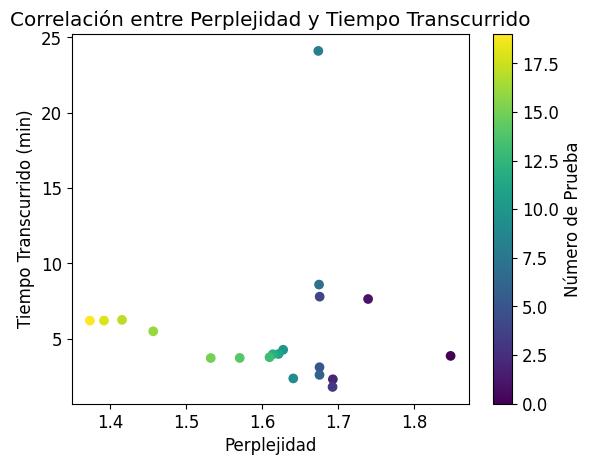

In [ ]:
plt.scatter(perplexity_values, elapsed_times, c=trial_numbers, cmap='viridis', marker='o')
plt.xlabel('Perplejidad')
plt.ylabel('Tiempo Transcurrido (min)')
plt.title('Correlación entre Perplejidad y Tiempo Transcurrido')
plt.colorbar(label='Número de Prueba')
plt.show()


In [ ]:
!pip install seaborn

In [ ]:
import pandas as pd
from datetime import timedelta

# Create DataFrames for each trial's eval loss, perplexity, and time
eval_loss_df = pd.DataFrame({'Número de Prueba': trial_numbers, 'Pérdida de Evaluación': eval_loss_values})
perplexity_df = pd.DataFrame({'Número de Prueba': trial_numbers, 'Perplejidad': perplexity_values})

# Calculate elapsed time for each trial
elapsed_times = [(completion_time - start_time).total_seconds() / 60 for start_time, completion_time in zip(start_times, completion_times)]
time_df = pd.DataFrame({'Número de Prueba': trial_numbers, 'Tiempo Transcurrido (min)': elapsed_times})

# Merge the DataFrames on 'Número de Prueba'
trial_data_df = pd.merge(eval_loss_df, perplexity_df, on='Número de Prueba')
trial_data_df = pd.merge(trial_data_df, time_df, on='Número de Prueba')

# Write the combined DataFrame to a CSV file
csv_filename = 'trial_data_combined.csv'
trial_data_df.to_csv(csv_filename, index=False)

print(f'DataFrame with evaluation loss, perplexity, and time has been successfully written to {csv_filename}.')


DataFrame with evaluation loss, perplexity, and time has been successfully written to trial_data_combined.csv.


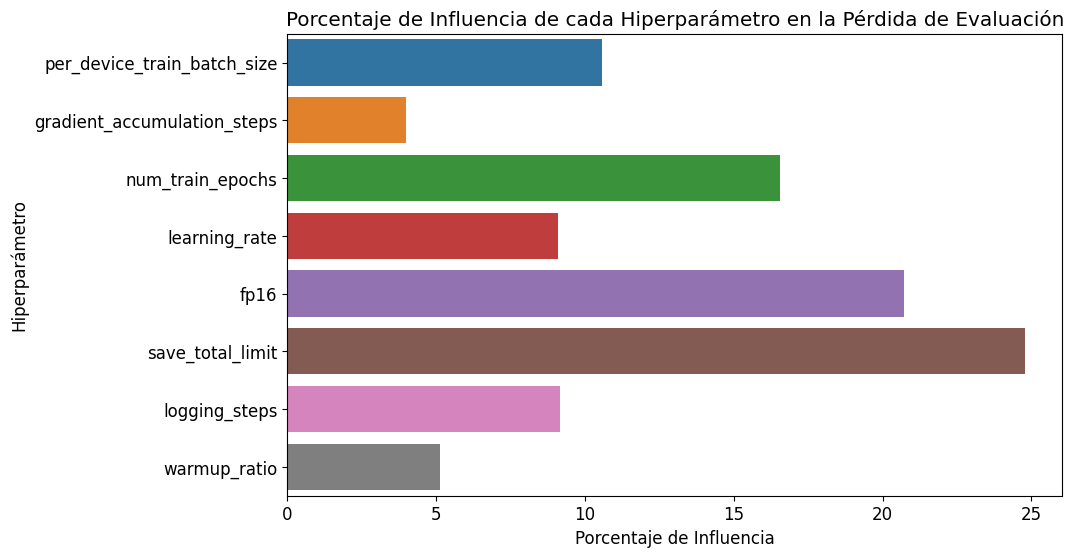

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Set Matplotlib to use Spanish labels
plt.rcParams.update({'font.size': 12, 'text.usetex': False, 'font.family': 'DejaVu Sans'})

# Retrieve the trial numbers, corresponding metric values, and hyperparameter values
trial_numbers = [trial.number for trial in study.trials]
eval_loss_values = [trial.value for trial in study.trials]

# Extract numeric hyperparameter names and values
numeric_params = [name for name, param in study.best_params.items() if isinstance(param, (int, float))]
numeric_values = [[trial.params[param] for trial in study.trials] for param in numeric_params]

# Calculate the correlation between each numeric parameter and evaluation loss
correlations = [abs(pearsonr(values, eval_loss_values)[0]) for values in numeric_values]

# Calculate the percentage of influence each parameter has on the final model
total_correlation = sum(correlations)
percentages = [(corr / total_correlation) * 100 for corr in correlations]

# Create a bar plot for the percentage of influence
plt.figure(figsize=(10, 6))
sns.barplot(x=percentages, y=numeric_params, orient='h')
plt.xlabel('Porcentaje de Influencia')
plt.ylabel('Hiperparámetro')
plt.title('Porcentaje de Influencia de cada Hiperparámetro en la Pérdida de Evaluación')
plt.show()


In [ ]:
training_args = transformers.TrainingArguments(
      per_device_train_batch_size=1,
      gradient_accumulation_steps=4,
      num_train_epochs=1,
      learning_rate=2e-4,
      fp16=True,
      save_total_limit=3,
      logging_steps=1,
      output_dir="experiments",
      optim="paged_adamw_8bit",
      lr_scheduler_type="cosine",
      warmup_ratio=0.05,
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False
trainer.train()

In [ ]:
results = trainer.evaluate()

In [ ]:
import math
perplexity = math.exp(results["eval_loss"])
print(f"Perplexity: {perplexity}")

Perplexity: 4.46669512015378


In [ ]:
results

{'eval_loss': 1.4966487884521484,
 'eval_runtime': 3.2568,
 'eval_samples_per_second': 23.028,
 'eval_steps_per_second': 3.07,
 'epoch': 1.0}

# Finetune the model

In [ ]:
training_args = transformers.TrainingArguments(
      per_device_train_batch_size=1,
      gradient_accumulation_steps=4,
      num_train_epochs=1,
      learning_rate=2e-4,
      fp16=True,
      save_total_limit=3,
      logging_steps=1,
      output_dir="experiments",
      optim="paged_adamw_8bit",
      lr_scheduler_type="cosine",
      warmup_ratio=0.05,
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=data,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False
trainer.train()

You are using 8-bit optimizers with a version of `bitsandbytes` < 0.41.1. It is recommended to update your version as a major bug has been fixed in 8-bit optimizers.
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,2.667600
2,2.747500
3,2.728000
4,2.554600
5,2.579900
6,2.991200
7,2.698200
8,2.715000
9,2.743000
10,2.629400


TrainOutput(global_step=233, training_loss=1.6200396827873753, metrics={'train_runtime': 234.459, 'train_samples_per_second': 3.979, 'train_steps_per_second': 0.994, 'total_flos': 2750274478682880.0, 'train_loss': 1.6200396827873753, 'epoch': 1.0})

In [ ]:
# Retrieve the best trial
best_trial = study.best_trial

# Use the best trial's hyperparameters
training_args = transformers.TrainingArguments(
    per_device_train_batch_size=best_trial.params["per_device_train_batch_size"],
    gradient_accumulation_steps=best_trial.params["gradient_accumulation_steps"],
    num_train_epochs=best_trial.params["num_train_epochs"],
    learning_rate=best_trial.params["learning_rate"],
    fp16=best_trial.params["fp16"],
    save_total_limit=best_trial.params["save_total_limit"],
    logging_steps=best_trial.params["logging_steps"],
    output_dir=best_trial.params["output_dir"],
    optim=best_trial.params["optim"],
    lr_scheduler_type=best_trial.params["lr_scheduler_type"],
    warmup_ratio=best_trial.params["warmup_ratio"],
)

# Assuming 'model' is the model you want to train
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Set model configuration to not use cache
model.config.use_cache = False

# Train the model
trainer.train()


Step,Training Loss
3,0.121200
6,0.128600
9,0.129500
12,0.137800
15,0.134900
18,0.141300
21,0.144600
24,0.144400
27,0.147500
30,0.124200


TrainOutput(global_step=78, training_loss=0.13050702176032922, metrics={'train_runtime': 308.6829, 'train_samples_per_second': 7.707, 'train_steps_per_second': 0.253, 'total_flos': 4558446470443008.0, 'train_loss': 0.13050702176032922, 'epoch': 2.93})

# Save trained model

In [ ]:
model.save_pretrained("trained-model")

In [ ]:
PEFT_MODEL = "lordjuacs/tesis-falcon-7b-finetuning"

model.push_to_hub(
    PEFT_MODEL, use_auth_token=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/_commit_api.py:282: UserWarning: About to update multiple times the same file in the same commit: 'adapter_model.bin'. This can cause undesired inconsistencies in your repo.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/_commit_api.py:282: UserWarning: About to update multiple times the same file in the same commit: 'adapter_config.json'. This can cause undesired inconsistencies in your repo.
  warnings.warn(


adapter_model.bin:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/lordjuacs/tesis-falcon-7b-finetuning/commit/4f41fff6817721aa67619fac7a9f002f22ada4cc', commit_message='Upload model', commit_description='', oid='4f41fff6817721aa67619fac7a9f002f22ada4cc', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
PEFT_MODEL = "lordjuacs/tesis-falcon-7b-finetuning"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
config = PeftConfig.from_pretrained(PEFT_MODEL)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer=AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

model = PeftModel.from_pretrained(model, PEFT_MODEL)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_errors.py:270 in                  │
│ hf_raise_for_status                                                                              │
│                                                                                                  │
│   267 │   </Tip>                                                                                 │
│   268 │   """                                                                                    │
│   269 │   try:                                                                                   │
│ ❱ 270 │   │   response.raise_for_status()                                                        │
│   271 │   except HTTPError as e:                                                                 │
│   272 │   │   error_code = response.headers.get("X-Error-Code")                                  │
│   273                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/requests/models.py:1021 in raise_for_status              │
│                                                                                                  │
│   1018 │   │   │   )                                                                             │
│   1019 │   │                                                                                     │
│   1020 │   │   if http_error_msg:                                                                │
│ ❱ 1021 │   │   │   raise HTTPError(http_error_msg, response=self)                                │
│   1022 │                                                                                         │
│   1023 │   def close(self):                                                                      │
│   1024 │   │   """Releases the connection back to the pool. Once this method has been            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
HTTPError: 404 Client Error: Not Found for url: https://huggingface.co/None/resolve/main/config.json

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:417 in cached_file             │
│                                                                                                  │
│    414 │   user_agent = http_user_agent(user_agent)                                              │
│    415 │   try:                                                                                  │
│    416 │   │   # Load from URL or cache if already cached                                        │
│ ❱  417 │   │   resolved_file = hf_hub_download(                                                  │
│    418 │   │   │   path_or_repo_id,                                                              │
│    419 │   │   │   filename,                                                                     │
│    420 │   │   │   subfolder=None if len(subfolder) == 0 else subfolder,                         │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:118 in _inner_fn    │
│                                                                                                  │
│   115 │   │   if check_use_auth_token:                                                           │
│   116 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   117 │   │                                                                              

# Run the finetuned model

In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [ ]:
#%%time
device = "cuda:0"

prompt = """
<pregunta>: en qué me ayuda el voluntariado?
<respuesta>:
""".strip()

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
  outputs = model.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 10>:11                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/peft/peft_model.py:762 in generate                       │
│                                                                                                  │
│    759 │   │   │   self.base_model.generation_config = self.generation_config                    │
│    760 │   │   try:                                                                              │
│    761 │   │   │   if not isinstance(peft_config, PromptLearningConfig):                         │
│ ❱  762 │   │   │   │   outputs = self.base_model.generate(**kwargs)                              │
│    763 │   │   │   else:                                                                         │
│    764 │   │   │   │   if "input_ids" not in kwargs:                                             │
│    765 │   │   │   │   │   raise ValueError("input_ids must be provided for Peft model generati  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/peft/peft_model.py:762 in generate                       │
│                                                                                                  │
│    759 │   │   │   self.base_model.generation_config = self.generation_config                    │
│    760 │   │   try:                                                                              │
│    761 │   │   │   if not isinstance(peft_config, PromptLearningConfig):                         │
│ ❱  762 │   │   │   │   outputs = self.base_model.generate(**kwargs)                              │
│    763 │   │   │   else:                                                                         │
│    764 │   │   │   │   if "input_ids" not in kwargs:                                             │
│    765 │   │   │   │   │   raise ValueError("input_ids must be provided for Peft model generati  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py:115 in decorate_context       │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1518 in generate        │
│                                                                                                  │
│   1515 │   │   │   │   )                                                                         │
│   1516 │   │   │                                                                                 │
│   1517 │   │   │   # 11. run greedy search                                                       │
│ ❱ 1518 │   │   │   return self.greedy_search(                                                    │
│   1519 │   │   │   │   input_ids,                          

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM

# Path to the local model directory
local_model_path = "xd"

# Load the configuration from the custom-named configuration file
config = AutoConfig.from_pretrained(local_model_path + "/adapter_config.json")

# Load the model using the custom-named configuration and model weights files
model = AutoModelForCausalLM.from_pretrained(local_model_path, config=config)

# You can also load the model weights separately if needed
# model.load_state_dict(torch.load(local_model_path + "/adapter_model.bin"))


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 7>:7                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/models/auto/configuration_auto.py:956 in    │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   953 │   │   │   │   if pattern in str(pretrained_model_name_or_path):                          │
│   954 │   │   │   │   │   return CONFIG_MAPPING[pattern].from_dict(config_dict, **unused_kwarg   │
│   955 │   │                                                                                      │
│ ❱ 956 │   │   raise ValueError(                                                                  │
│   957 │   │   │   f"Unrecognized model in {pretrained_model_name_or_path}. "                     │
│   958 │   │   │   f"Should have a `model_type` key in its {CONFIG_NAME}, or contain one of the   │
│   959 │   │   │   f"in its name: {', '.join(CONFIG_MAPPING.keys())}"                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Unrecognized model in xd/adapter_config.json. Should have a `model_type` key in its config.json, or 
contain one of the following strings in its name: albert, align, altclip, audio-spectrogram-transformer, 
autoformer, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, blenderbot, 
blenderbot-small, blip, blip-2, bloom, bridgetower, camembert, canine, chinese_clip, clap, clip, clipseg, codegen, 
conditional_detr, convbert, convnext, convnextv2, cpmant, ctrl, cvt, data2vec-audio, data2vec-text, 
data2vec-vision, deberta, deberta-v2, decision_transformer, deformable_detr, deit, deta, detr, dinat, distilbert, 
donut-swin, dpr, dpt, efficientformer, efficientnet, electra, encoder-decoder, ernie, ernie_m, esm, flaubert, 
flava, fnet, focalnet, fsmt, funnel, git, glpn, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, 
gptj, gptsan-japanese, graphormer, groupvit, hubert, ibert, imagegpt, informer, jukebox, layoutlm, layoutlmv2, 
layoutlmv3, led, levit, lilt, llama, longformer, longt5, luke, lxmert, m2m_100, marian, markuplm, mask2former, 
maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, mgp-str, mobilebert, mobilenet_v1, mobilenet_v2, 
mobilevit, mpnet, mt5, mvp, nat, nezha, nllb-moe, nystromformer, oneformer, open-llama, openai-gpt, opt, owlvit, 
pegasus, pegasus_x, perceiver, pix2struct, plbart, poolformer, prophetnet, qdqbert, rag, realm, reformer, regnet, 
rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rwkv, sam, segformer, sew, sew-d, 
speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, swiftformer, swin, 
swin2sr, swinv2, switch_transformers, t5, table-transformer, tapas, time_series_transformer, timesformer, 
trajectory_transformer, transfo-xl, trocr, tvlt, unispeech, unispeech-sat, upernet, van, videomae, vilt, 
vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, wav2vec2, 
wav2vec2-conformer, wavlm, whisper, xclip, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xmod, 
yolos, yoso